In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, precision_score,roc_auc_score
from sklearn.svm import SVC
from tqdm import tqdm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB


In [13]:
path = "/Users/saurabhraj/Desktop/CITY AI/Intro to AI/CW/Data"
df = pd.read_csv(path + "/data.csv")

In [14]:

def plot_consufion_matrix(cm, classes, title = 'Confusion Matrix', normalize = False,cmap = plt.cm.Blues ):
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        
    plt.imshow(cm,interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)
    plt.tight_layout()
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    
    for i in range(len(cm)):
        for j in range(len(cm[0])):
            plt.text(j,i,cm[i][j], color = 'red', size = 'xx-large', ha = 'center',weight='extra bold')
    
    
def print_evaluation_report(y_test, y_pred, y_pred_proba):
    """This function prints the merices involved for evalutions of the model.
        It also calls the confusioj matrix plot function
    """
    
    cm = confusion_matrix(y_test, y_pred)
    #np.set_printoptions(precision=2)
    #print(cm)
    f1 = f1_score(y_test, y_pred, average='macro')
    auc = roc_auc_score(y_test, y_pred_proba)
    precision = precision_score(y_test, y_pred)
    
    print('F1 Score : %.2f' % f1)
    print('AUC ROC : %.2f' % auc)
    print('Precision : %.2f' % precision)
    
    classes = [0,1]
    plt.figure()
    plot_consufion_matrix(cm, classes,title = 'Confusion Matrix', normalize = False)
    plt.show()
    return
    
    
    

# 2.2 Under Sampling (without PCA)

In [42]:
def undersample(df):
    count_minority = len(df[df['Bankrupt?'] == 1])
    df_minority = df[df['Bankrupt?'] == 1]
    df_majority = df[df['Bankrupt?'] == 0]
    df_majority_underSampled = df_majority.sample(n=count_minority)
    df_sampled = pd.concat([df_minority, df_majority_underSampled])
    
    return df_sampled

df_sampled = undersample(df)

print(f'DF under sampled shape : {df_sampled.shape}')


X = df_sampled.drop('Bankrupt?', axis=1)
y = df_sampled['Bankrupt?']
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.15, random_state=42,shuffle=True)
X_train, X_val, y_train, y_val = train_test_split(X_train,y_train, test_size = 0.20, random_state=42,shuffle=True)

print(f'X train shape : {X_train.shape}')
print(f'X val shape : {X_val.shape}')
print(f'X test shape : {X_test.shape}')

DF under sampled shape : (440, 96)
X train shape : (299, 95)
X val shape : (75, 95)
X test shape : (66, 95)


## Decision Tree

F1 Score : 0.80
AUC ROC : 0.82
Precision : 0.76


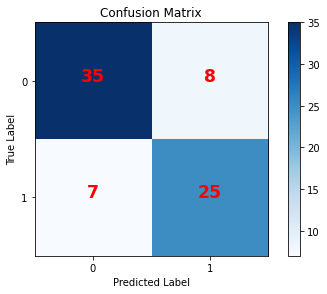

In [43]:
dt = DecisionTreeClassifier(max_depth=40, criterion='entropy', min_samples_split=10).fit(X_train,y_train)
y_pred = dt.predict(X_val)
y_pred_proba = dt.predict_proba(X_val)[:,1]
print_evaluation_report(y_val, y_pred, y_pred_proba)

## Support Vector Classifier

F1 Score : 0.59
AUC ROC : 0.63
Precision : 0.53


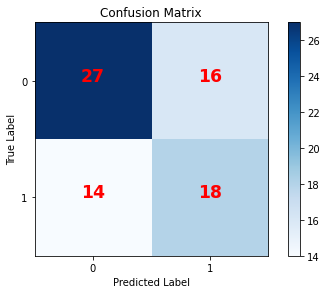

In [44]:
svc = SVC(C=100, kernel = 'rbf', probability=True).fit(X_train, y_train)
y_pred = svc.predict(X_val)
y_pred_proba = svc.predict_proba(X_val)[:,1]
print_evaluation_report(y_val, y_pred, y_pred_proba)

## KNN Classifier

F1 Score : 0.63
AUC ROC : 0.62
Precision : 0.58


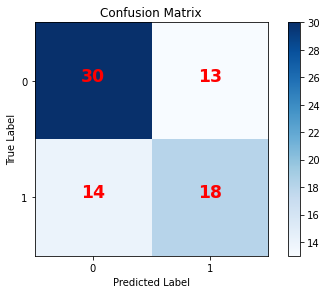

In [45]:
knn = KNeighborsClassifier(n_neighbors=10,weights='distance').fit(X_train, y_train)
y_pred = knn.predict(X_val)
y_pred_proba = knn.predict_proba(X_val)[:,1]
print_evaluation_report(y_val, y_pred, y_pred_proba)


## Random Forest

F1 Score : 0.88
AUC ROC : 0.97
Precision : 0.87


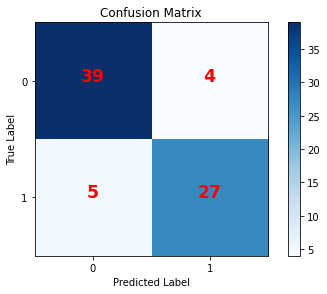

In [48]:
rf = RandomForestClassifier(n_estimators=200, criterion='log_loss').fit(X_train, y_train)
y_pred = rf.predict(X_val)
y_pred_proba = rf.predict_proba(X_val)[:,1]
print_evaluation_report(y_val, y_pred, y_pred_proba)

# Perceptron

Now I will try to train few neural networks and observe if I can improve the performance.


In [3]:
import tensorflow as tf

In [49]:
from sklearn.linear_model import Perceptron

ppn = Perceptron(max_iter=40,tol=0.001,eta0=1)
ppn.fit(X_train, y_train)

y_pred = ppn.predict(X_val)
score = ppn.score(X_val,y_val)
print(score)
#print_evaluation_report(y_test, y_pred, y_pred_proba)

0.4266666666666667


# Neural Networks (MLP)

In [58]:
#creating a callback function for our model which finds AUC, Recall and f1_score:


class Evaluation(tf.keras.callbacks.Callback):
    def __init__(self, train_data, val_data):
        super().__init__()
        self.train_data = train_data
        self.val_data = val_data
        
    def on_train_begin(self, logs={}):
        """Initializes list of scores for all epochs"""
        self.auc_val = []
        self.auc_train = []
        self.prec_val = []
        self.prec_train = []
        self.f1_val = []
        self.f1_train = []
        
    def on_epoch_end(self,epoch, logs):
        """Appends the score at the end of each epoch in the initilized emplty list of scores."""
        val_score = np.array(self.model.predict(self.val_data[0]))
        train_score = np.array(self.model.predict(self.train_data[0]))
        val_pred = np.round(val_score)
        train_pred = np.round(train_score)
        val_target = self.val_data[1]
        train_target = self.train_data[1]
        
        self.auc_val.append(roc_auc_score(val_target, val_score))
        self.auc_train.append(roc_auc_score(train_target, train_score))
        
        self.prec_val.append(precision_score(val_target, val_pred))
        self.prec_train.append(precision_score(train_target, train_pred))
        
        self.f1_val.append(f1_score(val_target, val_pred, average='macro'))
        self.f1_train.append(f1_score(train_target, train_pred, average='macro'))
        
        return
        
        
        
    

In [26]:
from tensorflow.keras.layers import Dense,Input,Activation,Dropout,Flatten,Embedding, LSTM, Concatenate, Conv1D, BatchNormalization
from tensorflow.keras.models import Model, Sequential
import random as rn
import tensorflow as tf
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [28]:
X_train.shape

(352, 95)

In [122]:
n1 = 128
n2 = 512
n3 = 128
n4 = 64
model = Sequential()
model.add(Input(shape=(95,)))
model.add(Dense(n1,activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(n2, activation='relu'))
#model.add(Dropout(0.1))
model.add(Dense(n3, activation='relu'))
model.add(Dense(n4, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.summary()

tf.keras.utils.plot_model(model)

Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_61 (Dense)            (None, 128)               12288     
                                                                 
 dropout_10 (Dropout)        (None, 128)               0         
                                                                 
 dense_62 (Dense)            (None, 512)               66048     
                                                                 
 dense_63 (Dense)            (None, 128)               65664     
                                                                 
 dense_64 (Dense)            (None, 64)                8256      
                                                                 
 dense_65 (Dense)            (None, 1)                 65        
                                                                 
Total params: 152,321
Trainable params: 152,321
Non-t

In [123]:

es_callback = EarlyStopping(monitor='loss', patience = 5, min_delta=0.0001)
metric_callback = Evaluation((X_train,y_train), (X_val,y_val))
my_callbacks = [es_callback, metric_callback]

model.compile(loss='binary_crossentropy', optimizer='adam')

model.fit(X_train,y_train, epochs=500,validation_data=(X_val, y_val), callbacks=my_callbacks )


Epoch 1/500
10/10 [==============================] - 0s 16ms/step - loss: 69574016.0000 - val_loss: 35714180.0000
Epoch 2/500
10/10 [==============================] - 0s 10ms/step - loss: 23852584.0000 - val_loss: 34624864.0000
Epoch 3/500
10/10 [==============================] - 0s 9ms/step - loss: 16338410.0000 - val_loss: 26024536.0000
Epoch 4/500
10/10 [==============================] - 0s 9ms/step - loss: 9903791.0000 - val_loss: 11306496.0000
Epoch 5/500
10/10 [==============================] - 0s 9ms/step - loss: 8616080.0000 - val_loss: 9192199.0000
Epoch 6/500
10/10 [==============================] - 0s 9ms/step - loss: 6646270.5000 - val_loss: 6037468.0000
Epoch 7/500
10/10 [==============================] - 0s 9ms/step - loss: 5927406.5000 - val_loss: 11030219.0000
Epoch 8/500
10/10 [==============================] - 0s 9ms/step - loss: 5383212.5000 - val_loss: 6873492.5000
Epoch 9/500
10/10 [==============================] - 0s 9ms/step - loss: 4435793.5000 - val_loss: 5053

In [124]:
def print_evaluation_report_NN():
    """Print the evaluation report of neural networks:"""
    y_pred_proba = np.asarray(model.predict(X_test))
    y_pred = np.round(np.asarray(model.predict(X_test)))
    print_evaluation_report(y_test, y_pred, y_pred_proba)
    


    auc_train = my_callbacks[1].auc_train
    auc_val = my_callbacks[1].auc_val
    
    n = len(auc_train)

    plt.plot(list(range(n)), auc_train)
    plt.plot(list(range(n)), auc_val)
    plt.title('model AUC')
    plt.legend(['train', 'val'], loc='upper left')
    plt.ylabel('AUC')
    plt.xlabel('epoch')
    plt.show()


    f1_train = my_callbacks[1].f1_train
    f1_val = my_callbacks[1].f1_val

    plt.plot(list(range(n)), f1_train)
    plt.plot(list(range(n)), f1_val)
    plt.title('model F1')
    plt.legend(['train', 'val'], loc='upper left')
    plt.ylabel('f1_score')
    plt.xlabel('epoch')
    plt.show()


    prec_train = my_callbacks[1].prec_train
    prec_val = my_callbacks[1].prec_val

    plt.plot(list(range(n)), f1_train)
    plt.plot(list(range(n)), f1_val)
    plt.title('model Precision')
    plt.legend(['train', 'val'], loc='upper left')
    plt.ylabel('precision_score')
    plt.xlabel('epoch')
    plt.show()


3/3 [==============================] - 0s 830us/step
F1 Score : 0.54
AUC ROC : 0.56
Precision : 0.64


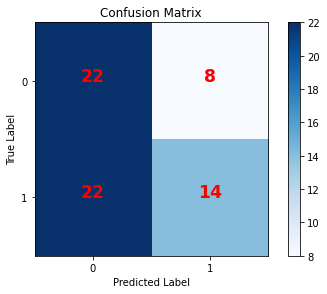

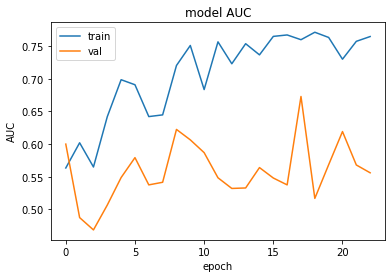

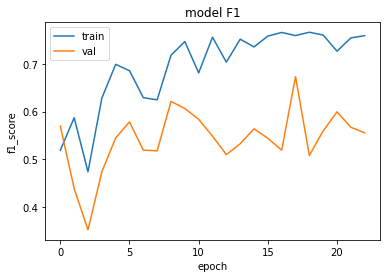

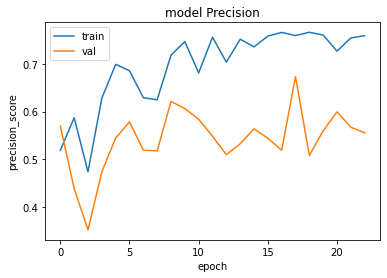

In [125]:
print_evaluation_report_NN()

* As I increased the number of hidden neurons, the model tend to overfit.
* As I increased the dropout rates, the validation score started deviating a lot with train scores.

In [129]:
## Apply SMOTE and see the performace